## data preparation

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices())

2023-11-20 17:03:17.853497: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 17:03:18.104232: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 17:03:18.104297: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 17:03:18.105161: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 17:03:18.216339: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-20 17:03:20.022464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 17:03:20.045079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 17:03:20.045261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
POINTS_NUM = 10

import numpy as np
points = np.load(f'/host/dissertation/proccessed_data/points_{POINTS_NUM}.npy')
pt = np.load('/host/dissertation/proccessed_data/pt.npy')
# pt = (np.load('/host/dissertation/proccessed_data/pt.npy')-1.)/9.

print(np.min(pt), np.max(pt))

1.0008341073989868 9.992623329162598


In [3]:
import sys
ABS_ROOT_DIR_PATH = '/host/dissertation/'
if ABS_ROOT_DIR_PATH not in sys.path:
    sys.path.append(ABS_ROOT_DIR_PATH)

## manual testing

### 1/pt

In [23]:
import cvnn.layers as complex_layers

# from common.model import sigmoid_real_with_abs
from tensorflow import Tensor
from tensorflow.keras.activations import sigmoid, relu
def sigmoid_real_with_abs(z: Tensor) -> Tensor:
    return sigmoid(tf.math.abs(z))
def capped_relu_with_abs(z: Tensor) -> Tensor:
    return tf.math.reduce_min(relu(tf.math.abs(z)),1)

model = tf.keras.models.Sequential()
model.add(complex_layers.ComplexInput(input_shape=(POINTS_NUM,)))
model.add(complex_layers.ComplexDense(units=128, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=128, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=128, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=128, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=1, activation='convert_to_real_with_abs')) #'convert_to_real_with_abs'
model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1.), loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])
model.summary(expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 128)               2816      
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_3 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_4 (ComplexDe  (None, 1)                 2

In [24]:
from common.model import FreeMemory
history = model.fit(points, 1/pt, epochs=250, validation_split=0.2, verbose=0, callbacks=[FreeMemory(25)])

epoch 0 ended, info: {'loss': 1813.708740234375, 'mean_absolute_percentage_error': 18386.673828125, 'val_loss': 704.07568359375, 'val_mean_absolute_percentage_error': 11607.3974609375}
epoch 25 ended, info: {'loss': 0.030191821977496147, 'mean_absolute_percentage_error': 59.16695022583008, 'val_loss': 0.03193075954914093, 'val_mean_absolute_percentage_error': 53.010643005371094}
epoch 50 ended, info: {'loss': 0.016959505155682564, 'mean_absolute_percentage_error': 42.80035400390625, 'val_loss': 0.020016968250274658, 'val_mean_absolute_percentage_error': 50.7717399597168}
epoch 75 ended, info: {'loss': 0.012877557426691055, 'mean_absolute_percentage_error': 37.28363037109375, 'val_loss': 0.017960745841264725, 'val_mean_absolute_percentage_error': 38.62910079956055}
epoch 100 ended, info: {'loss': 0.01018416415899992, 'mean_absolute_percentage_error': 33.77521896362305, 'val_loss': 0.022695215418934822, 'val_mean_absolute_percentage_error': 49.05643081665039}
epoch 125 ended, info: {'los

1st percentile of train mean_absolute_percentage_error:       2.2900e+01
1st percentile of validation mean_absolute_percentage_error:  3.3427e+01


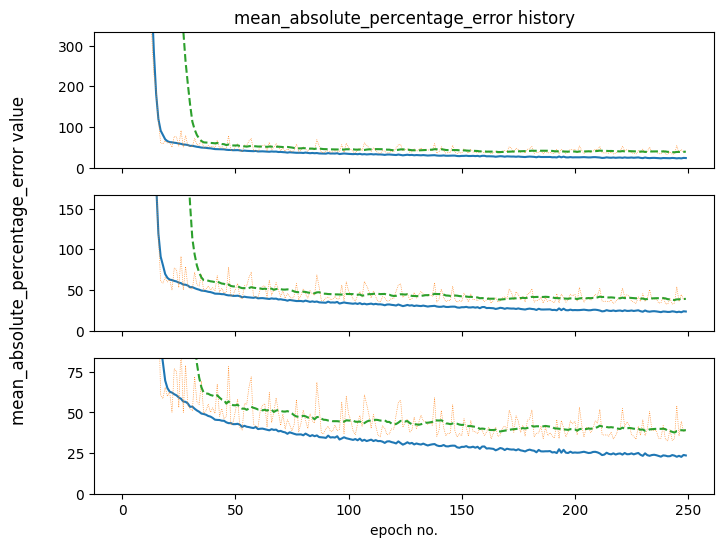

In [25]:
from common.plot import plot_metric_history_zoomed
plot_metric_history_zoomed(history, moving_average_window = (20,), metric='mean_absolute_percentage_error', legend_loc=None)

256/256 [==============================] - 0s 638us/step


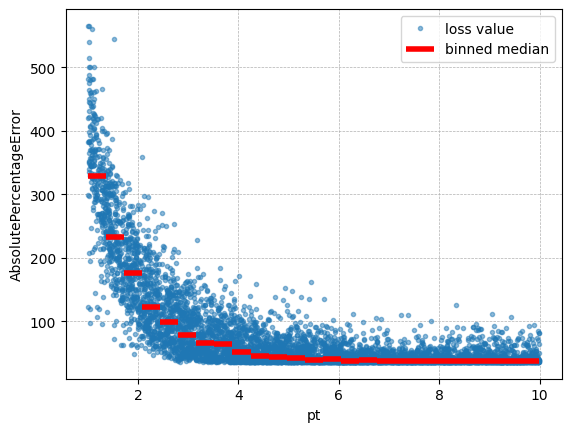

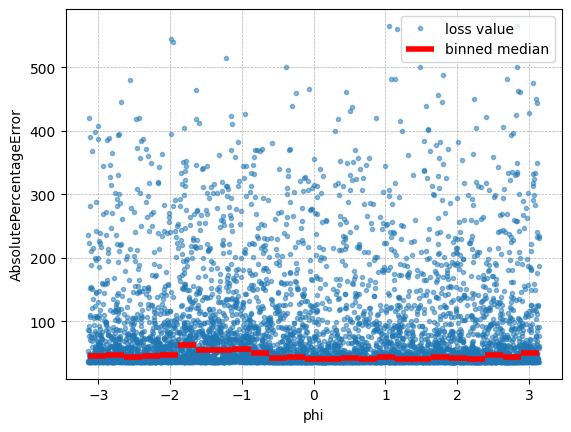

In [30]:
from common.plot import plot_loss_by_parameter
from common.utils import validation_set, train_set

metric = tf.keras.losses.MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.NONE)
result = metric(1/pt, model.predict(points))

plot_loss_by_parameter(loss=train_set(result), parameter=train_set(pt), 
                       loss_label='AbsolutePercentageError', parameter_label='pt', 
                       statistic='median')#, ylim=(50,100))
phi = np.load('/host/dissertation/proccessed_data/phi.npy') 
plot_loss_by_parameter(loss=train_set(result), parameter=train_set(phi), 
                       loss_label='AbsolutePercentageError', parameter_label='phi', 
                       statistic='median')#, ylim=(50,100))

### pt

In [4]:
import cvnn.layers as complex_layers

# from common.model import sigmoid_real_with_abs
from tensorflow import Tensor
from tensorflow.keras.activations import sigmoid, relu
def sigmoid_real_with_abs(z: Tensor) -> Tensor:
    return sigmoid(tf.math.abs(z))
def capped_relu_with_abs(z: Tensor) -> Tensor:
    return tf.math.reduce_min(relu(tf.math.abs(z)),1)

model = tf.keras.models.Sequential()
model.add(complex_layers.ComplexInput(input_shape=(POINTS_NUM,)))
model.add(complex_layers.ComplexDense(units=128, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=128, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=128, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=128, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=1, activation='convert_to_real_with_abs')) #'convert_to_real_with_abs'
model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1.), loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])
model.summary(expand_nested=True)

2023-11-20 17:04:35.797280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 17:04:35.797387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 17:04:35.797446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 128)               2816      
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_3 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_4 (ComplexDe  (None, 1)                 2

In [5]:
from common.model import FreeMemory
history = model.fit(points, pt, epochs=250, validation_split=0.2, verbose=0, callbacks=[FreeMemory(25)])

2023-11-20 17:04:53.038020: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8f4c0b6ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-20 17:04:53.038032: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-11-20 17:04:53.177771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-20 17:04:53.211003: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch 0 ended, info: {'loss': 1385.2164306640625, 'mean_absolute_percentage_error': 748.9740600585938, 'val_loss': 642.993408203125, 'val_mean_absolute_percentage_error': 533.4993286132812}
epoch 25 ended, info: {'loss': 7.099282741546631, 'mean_absolute_percentage_error': 63.74967956542969, 'val_loss': 7.758074760437012, 'val_mean_absolute_percentage_error': 67.39595794677734}
epoch 50 ended, info: {'loss': 4.528637886047363, 'mean_absolute_percentage_error': 46.90770721435547, 'val_loss': 6.013761043548584, 'val_mean_absolute_percentage_error': 57.09431457519531}
epoch 75 ended, info: {'loss': 3.4763903617858887, 'mean_absolute_percentage_error': 38.26010513305664, 'val_loss': 6.111995697021484, 'val_mean_absolute_percentage_error': 51.29990768432617}
epoch 100 ended, info: {'loss': 2.8762104511260986, 'mean_absolute_percentage_error': 33.679718017578125, 'val_loss': 4.615292549133301, 'val_mean_absolute_percentage_error': 44.805519104003906}
epoch 125 ended, info: {'loss': 2.5282866

1st percentile of train mean_absolute_percentage_error:       2.3734e+01
1st percentile of validation mean_absolute_percentage_error:  3.7885e+01


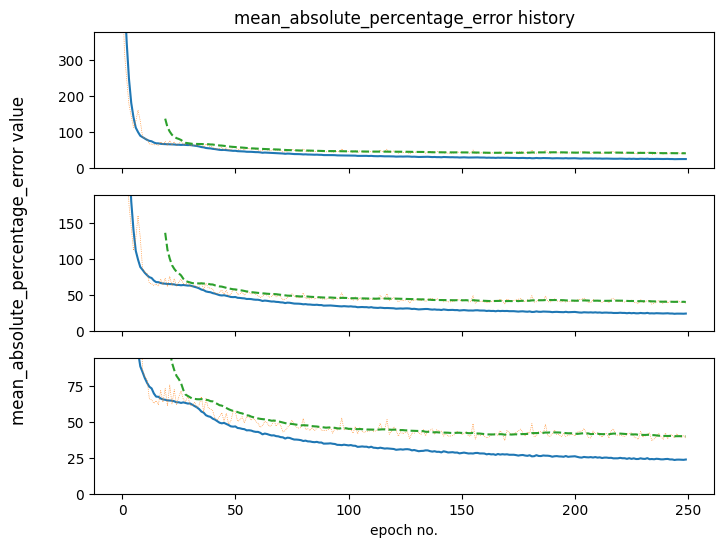

In [6]:
from common.plot import plot_metric_history_zoomed
plot_metric_history_zoomed(history, moving_average_window = (20,), metric='mean_absolute_percentage_error', legend_loc=None)

256/256 [==============================] - 0s 675us/step


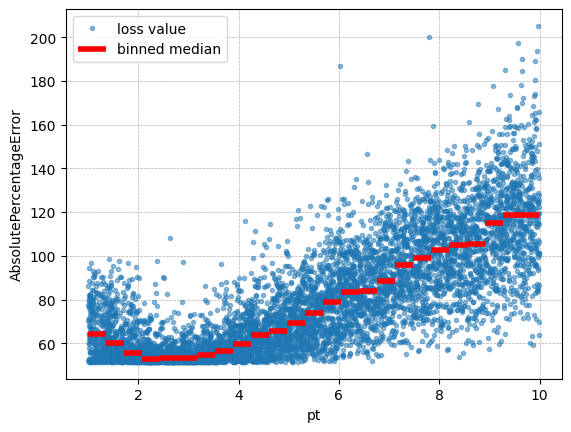

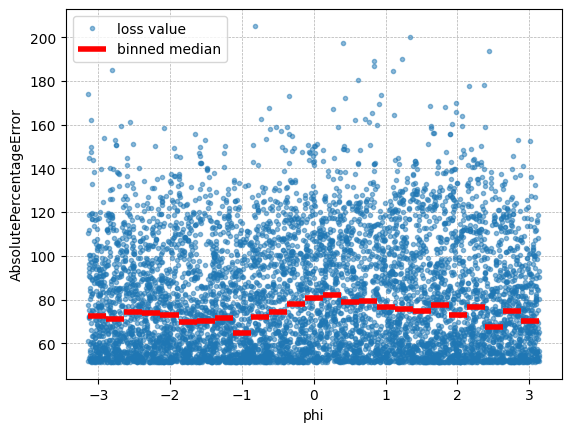

In [7]:
from common.plot import plot_loss_by_parameter
from common.utils import validation_set, train_set

metric = tf.keras.losses.MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.NONE)
result = metric(pt, model.predict(points))

plot_loss_by_parameter(loss=train_set(result), parameter=train_set(pt), 
                       loss_label='AbsolutePercentageError', parameter_label='pt', 
                       statistic='median')#, ylim=(50,100))
phi = np.load('/host/dissertation/proccessed_data/phi.npy') 
plot_loss_by_parameter(loss=train_set(result), parameter=train_set(phi), 
                       loss_label='AbsolutePercentageError', parameter_label='phi', 
                       statistic='median')#, ylim=(50,100))

## space search

In [8]:
from common.search import ConfigsTester

configs_tester = ConfigsTester(spacepoints_number_space = [10],
                               hiddenlayers_number_space = [1,2,3,4,5],
                               hiddenlayers_neurons_number_space = [256,192,128,64],
                               hiddenlayers_activation_func_space = ['cart_relu',],#'pol_sigmoid','pol_tanh','cart_sigmoid','cart_tanh',
                               outputlayer_activation_func_space = ['convert_to_real_with_abs',],
                               metric = 'mean_absolute_percentage_error',
                               save_path='/host/dissertation/trained_models/pt/')

In [9]:
import cvnn.layers as complex_layers
from common.model import FreeMemory

configs_tester.test_configs(y_data=1/pt,
                            optimizer_factory=lambda: tf.keras.optimizers.SGD(clipnorm=1.),
                            loss='mean_squared_error',#'mean_squared_error', 
                            epochs=600,
                            scenario='1/pt cart_relu tweaking',
                            callbacks=[FreeMemory()])

START (10, 1, 256, 'cart_relu', 'convert_to_real_with_abs')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (10, 1, 256, 'cart_relu', 'convert_to_real_with_abs')
START (10, 1, 192, 'cart_relu', 'convert_to_real_with_abs')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (10, 1, 192, 'cart_relu', 'convert_to_real_with_abs')
START (10, 1, 128, 'cart_relu', 'convert_to_real_with_abs')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (10, 1, 128, 'cart_relu', 'convert_to_real_with_abs')
START (10, 1, 64, 'cart_relu', 'convert_to_real_with_abs')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (10, 1, 64, 'cart_relu', 'convert_to_real_with_abs')
START (10, 2, 256, 'cart_relu', 'c